# Simple Model
The aim of this workbook it to take an extremely simplified version of the model (just debris) and then build the equations and solve for them to ensure that the model is working correctly before implementing.

In [156]:
import dill as pickle
import sympy as sp
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from numba import jit, prange
import os   

In [157]:
with open(os.path.join(os.getcwd(), '../../scenario_properties_long.pkl'), 'rb') as f:
    scenario_properties = pickle.load(f)

In [158]:
# Lambdafiying the equations
symbols = scenario_properties.all_symbolic_vars

# Convert to symbols
print(len(symbols)) # Should be 320 for a 40, 8 matrix
print(symbols)

equations_flattened = [scenario_properties.equations[i, j] for j in range(scenario_properties.equations.cols) for i in range(scenario_properties.equations.rows)]
#drag_flattened = [scenario_properties.full_drag[i, j] for j in range(scenario_properties.full_drag.cols) for i in range(scenario_properties.full_drag.rows)]

# Convert equations to lambda functions
equations = [sp.lambdify(symbols, eq, 'numpy') for eq in equations_flattened]
#full_drag = [sp.lambdify(symbols, eq, 'numpy') for eq in drag_flattened]

600
[Su_260kg_1, Su_260kg_2, Su_260kg_3, Su_260kg_4, Su_260kg_5, Su_260kg_6, Su_260kg_7, Su_260kg_8, Su_260kg_9, Su_260kg_10, Su_260kg_11, Su_260kg_12, Su_260kg_13, Su_260kg_14, Su_260kg_15, Su_260kg_16, Su_260kg_17, Su_260kg_18, Su_260kg_19, Su_260kg_20, Su_260kg_21, Su_260kg_22, Su_260kg_23, Su_260kg_24, Su_260kg_25, Su_260kg_26, Su_260kg_27, Su_260kg_28, Su_260kg_29, Su_260kg_30, Su_260kg_31, Su_260kg_32, Su_260kg_33, Su_260kg_34, Su_260kg_35, Su_260kg_36, Su_260kg_37, Su_260kg_38, Su_260kg_39, Su_260kg_40, Su_473kg_1, Su_473kg_2, Su_473kg_3, Su_473kg_4, Su_473kg_5, Su_473kg_6, Su_473kg_7, Su_473kg_8, Su_473kg_9, Su_473kg_10, Su_473kg_11, Su_473kg_12, Su_473kg_13, Su_473kg_14, Su_473kg_15, Su_473kg_16, Su_473kg_17, Su_473kg_18, Su_473kg_19, Su_473kg_20, Su_473kg_21, Su_473kg_22, Su_473kg_23, Su_473kg_24, Su_473kg_25, Su_473kg_26, Su_473kg_27, Su_473kg_28, Su_473kg_29, Su_473kg_30, Su_473kg_31, Su_473kg_32, Su_473kg_33, Su_473kg_34, Su_473kg_35, Su_473kg_36, Su_473kg_37, Su_473kg_38,

In [159]:
full_lambda_flattened = []

for i in range(len(scenario_properties.full_lambda)):
    if scenario_properties.full_lambda[i] is not None:
        full_lambda_flattened.extend(scenario_properties.full_lambda[i])
    else:
        # Append None to the list, length of scenario_properties.n_shells
        full_lambda_flattened.extend([None]*scenario_properties.n_shells)

In [160]:
full_lambda_flattened[1]

In [161]:
x0_flattened = scenario_properties.x0.T.values.flatten()
times = np.array(scenario_properties.scen_times)

# Initial population needs to be in one columnn, so now the intiial population is in one. Species 1 is the first 40 rows, species 2 is the next 40 rows, etc.
def population_shell(t, N, full_lambda, equations):
    # Initialize the rate of change array
    dN_dt = np.zeros_like(N)

    # Iterate over each component in N
    for i in range(len(N)):
       
        # Compute and add the external modification rate, if applicable
        # Now using np.interp to calculate the increase
        if full_lambda[i] is not None:
            increase = np.interp(t, times, full_lambda[i])
            # If increase is nan set to 0
            if np.isnan(increase):
                increase = 0
            
            else:
                dN_dt[i] += increase

        # Compute the intrinsic rate of change from the differential equation
        change = equations[i](*N)

        if N[i] < 0:
            N[i] = 0
            dN_dt[i] = 0
        else:
            dN_dt[i] += change

    return dN_dt

output = solve_ivp(population_shell, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0_flattened, args=(full_lambda_flattened, equations), 
                   t_eval=scenario_properties.scen_times, method='BDF', max_step=1, rtol=1e-11, atol=1e-11)

In [162]:
scenario_properties.x0

,Su_260kg,Su_473kg,S_148kg,S_750kg,S_1250kg,sns,N_0.00141372kg,N_0.567kg,N_6kg,N_148kg,N_260kg,N_473kg,N_750kg,N_1250kg,B
alt_bin,,,,,,,,,,,,,,,
0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0
1,2,0,0,0,0,1,0,0,1,1,0,0,0,0,0
2,11,0,0,0,0,1,0,0,4,2,0,0,0,0,3
3,14,1,0,0,0,1,0,1,9,2,0,0,0,1,1
4,30,0,0,0,0,16,0,3,8,5,1,0,0,0,2
5,43,0,0,0,0,9,0,5,28,10,0,0,0,0,2
6,44,2,0,0,0,11,0,5,30,15,0,0,0,1,7
7,117,3,0,0,0,7,0,3,37,25,1,0,0,0,10
8,161,4,0,0,0,17,0,2,62,30,0,0,0,0,17


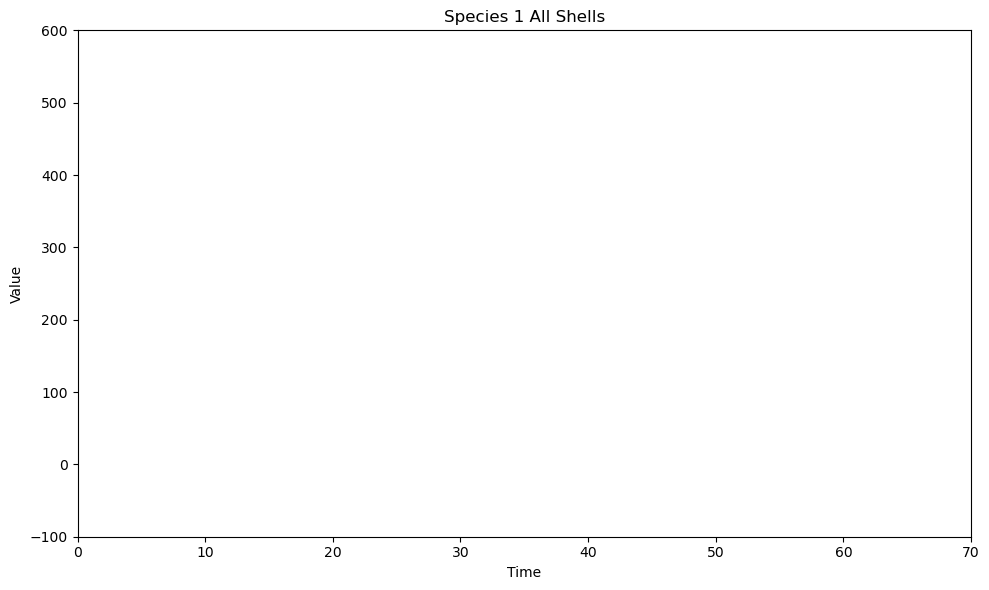

In [163]:
plt.figure(figsize=(10, 6))

# Assuming output.y has a shape of (n_variables, n_time_points)
# Loop over the first 40 variables (or species shells)
for i in range(121, 160):
    plt.plot(output.t, output.y[i], label=f'Species Shell {i+1}')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Species 1 All Shells')
plt.xlim(0, 70)
plt.ylim(-100, 600)

# Optional: Create a legend outside the plot
#plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()  # Adjust layout to make room for the legend
plt.show()


In [164]:
print(scenario_properties.species_names)

['Su_260kg', 'Su_473kg', 'S_148kg', 'S_750kg', 'S_1250kg', 'sns', 'N_0.00141372kg', 'N_0.567kg', 'N_6kg', 'N_148kg', 'N_260kg', 'N_473kg', 'N_750kg', 'N_1250kg', 'B']


C:\Users\IT\AppData\Local\Temp\ipykernel_3216\1473389937.py:32: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.xlim(0, max(output.t))


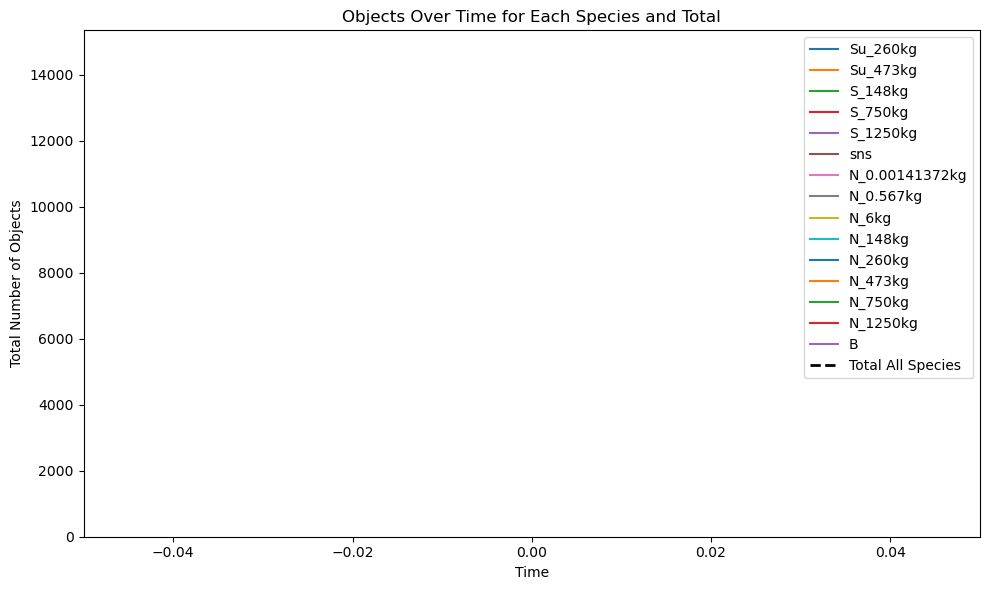

In [165]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming scenario_properties.species_names is available
species_names = scenario_properties.species_names

plt.figure(figsize=(10, 6))

# Assuming output.y's shape is (n_variables, n_time_points) and is ordered by species
num_species = len(species_names)
num_shells = 40  # Number of shells per species

# Initialize an array to hold the total number of objects at each time point
total_objects_all_species = np.zeros_like(output.t)

# Sum and plot for each species, using species names for labels
for i in range(num_species):
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    total_objects_per_species = np.sum(output.y[start_idx:end_idx, :], axis=0)  # Sum along the vertical axis
    plt.plot(output.t, total_objects_per_species, label=f'{species_names[i]}')
    
    # Add to the total objects count
    total_objects_all_species += total_objects_per_species

# Plot the total sum line
plt.plot(output.t, total_objects_all_species, label='Total All Species', color='k', linewidth=2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Total Number of Objects')
plt.title('Objects Over Time for Each Species and Total')
plt.xlim(0, max(output.t))
# Adjust the ylim based on the range of total_objects_all_species if necessary
plt.ylim(0, np.max(total_objects_all_species) * 1.1)

plt.legend()
plt.tight_layout()
plt.show()


In [166]:
interpolated_values = [np.interp(scenario_properties.scen_times, times, fl) if fl is not None else None for fl in full_lambda_flattened]

In [167]:
import numpy as np
from scipy.integrate import solve_ivp
from sympy import simplify

equations_optimized = [simplify(eq) for eq in scenario_properties.equations]


# Pre-compute interpolated values for each full_lambda entry
def population_shell(t, N, full_lambda, equations, symbols):
    dN_dt = np.zeros_like(N)
    # Find the index in scen_times closest to t
    idx = np.searchsorted(scenario_properties.scen_times, t, side='right') - 1

    print(t)
    
    for i, eq in enumerate(equations):
        # Create a substitution dictionary
        subs_dict = {sym: val for sym, val in zip(symbols, N)}
        # Use subs to substitute N values into the equation and evalf to evaluate it
        dN_dt[i] = eq.subs(subs_dict).evalf()

        if full_lambda[i] is not None:
            increase = full_lambda[i][idx] if idx < len(full_lambda[i]) else full_lambda[i][-1]
            if np.isnan(increase):
                increase = 0
            else:
                dN_dt[i] += increase
        
    return dN_dt

# Solve the ODE with pre-computed interpolated values
output = solve_ivp(population_shell, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0_flattened, 
                   args=(full_lambda_flattened, scenario_properties.equations, equations_optimized), t_eval=scenario_properties.scen_times, method='BDF', rtol=1e-4, atol=1e-4)


0.0


TypeError: Cannot convert expression to float

In [ ]:
# Assuming scenario_properties.equations, .full_drag, and .full_lambda are as described

# Make sure symbols is a list of SymPy symbols, not strings or anything else
symbols = scenario_properties.all_symbolic_vars # This should already be a list of SymPy symbols
times = np.array(scenario_properties.scen_times)
x0_flattened = scenario_properties.x0.T.values.flatten()

def population_shell(t, N, full_lambda, equations):
    # Initialize the rate of change array
    dN_dt = np.zeros_like(N)

    # Create a substitution dictionary from symbols to N values
    subs_dict = dict(zip(symbols, N))

    for i in range(len(N)):
        # Compute and add the external modification rate, if applicable
        if full_lambda[i] is not None:
            increase = np.interp(t, times, full_lambda[i])
            # If increase is nan, set to 0
            if np.isnan(increase):
                increase = 0
            dN_dt[i] += increase

        # Compute the intrinsic rate of change from the differential equation
        # Using subs and evalf to evaluate the expression
        dN_dt[i] += equations[i].subs(subs_dict).evalf()

    return dN_dt

# Initial conditions and time span setup remains the same

# Solve the ODE
output = solve_ivp(lambda t, N: population_shell(t, N, full_lambda_flattened, scenario_properties.equations), 
                   [times[0], times[-1]], x0_flattened, 
                   t_eval=times, method='BDF', max_step=1, rtol=1e-6, atol=1e-6)

NameError: name 'full_lambda_flattened' is not defined

[-1.04894741604327e-8*pi*N_0p00141372kg_1*Su_260kg_1 - 1.42472603142352e-8*pi*N_0p567kg_1*Su_260kg_1 - 4.0828598495625e-8*pi*N_260kg_1*Su_260kg_1 - 1.51592799913287e-7*pi*N_473kg_1*Su_260kg_1 - 1.33813040872173e-8*pi*N_6kg_1*Su_260kg_1 - 8.16571969912501e-18*pi*Su_260kg_1**2 - 1.51592799913287e-17*pi*Su_260kg_1*Su_473kg_1 - 1.33813040872173e-13*pi*Su_260kg_1*sns_1 - 0.125*Su_260kg_1,
 -1.03946637967275e-8*pi*N_0p00141372kg_2*Su_260kg_2 - 1.41184847520349e-8*pi*N_0p567kg_2*Su_260kg_2 - 4.04595643368352e-8*pi*N_260kg_2*Su_260kg_2 - 1.50222610304633e-7*pi*N_473kg_2*Su_260kg_2 - 1.32603555736927e-8*pi*N_6kg_2*Su_260kg_2 - 8.09191286736704e-18*pi*Su_260kg_2**2 - 1.50222610304633e-17*pi*Su_260kg_2*Su_473kg_2 - 1.32603555736927e-13*pi*Su_260kg_2*sns_2 - 0.125*Su_260kg_2,
 -1.03011330791907e-8*pi*N_0p00141372kg_3*Su_260kg_3 - 1.39914472609516e-8*pi*N_0p567kg_3*Su_260kg_3 - 4.00955109958466e-8*pi*N_260kg_3*Su_260kg_3 - 1.48870914010572e-7*pi*N_473kg_3*Su_260kg_3 - 1.31410394903778e-8*pi*N_6kg_3

In [ ]:
# Lets create a test case ODE to see what happens

# Define 1 ODE
ODE = scenario_properties.full_Cdot_PMD[0]
print(ODE)

# Get the sympy symbols
symbols = ODE.free_symbols

# Convert to lambda function
ODE_lambda = sp.lambdify(symbols(1), ODE, 'numpy')
print(ODE_lambda)

x0 = np.array[1]

# Define the function


-0.125*Su_260kg_1


AttributeError: 'set' object has no attribute 'values'

In [ ]:


scenario_properties.full_lambda[0]

[None,
 None,
 array([3.96014039, 7.92028079, 0.        , 0.        , 0.        ,
        0.        , 3.96014039, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 3.96014039,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 3.96014039,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 3.96014039,
        0.        , 0.        , 3.96014039, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        3.96014039, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 3.96014039, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.

(0.0, 2000.0)

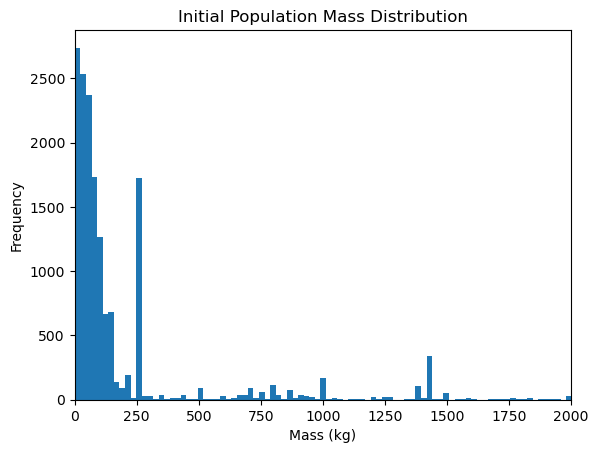

In [179]:
# open initial_population.csv as a pandas dataframe
df = pd.read_csv(r'C:\Users\IT\Documents\UCL\pyssem\initial_population.csv')

# Create a histogram of the df on mass
plt.hist(df['mass'], bins=500)
plt.title('Initial Population Mass Distribution')
plt.xlabel('Mass (kg)')
plt.ylabel('Frequency')
plt.xlim(0, 2000)

In [198]:
print(scenario_properties.x0)

         Su_260kg  Su_473kg  S_148kg  S_750kg  S_1250kg  sns  N_0.00141372kg  \
alt_bin                                                                        
0               2         0        0        0         0    0               0   
1               2         0        0        0         0    1               0   
2              11         0        0        0         0    1               0   
3              14         1        0        0         0    1               0   
4              30         0        0        0         0   16               0   
5              43         0        0        0         0    9               0   
6              44         2        0        0         0   11               0   
7             117         3        0        0         0    7               0   
8             161         4        0        0         0   17               0   
9             212        27        0        0         0   34               1   
10            265        27        0    

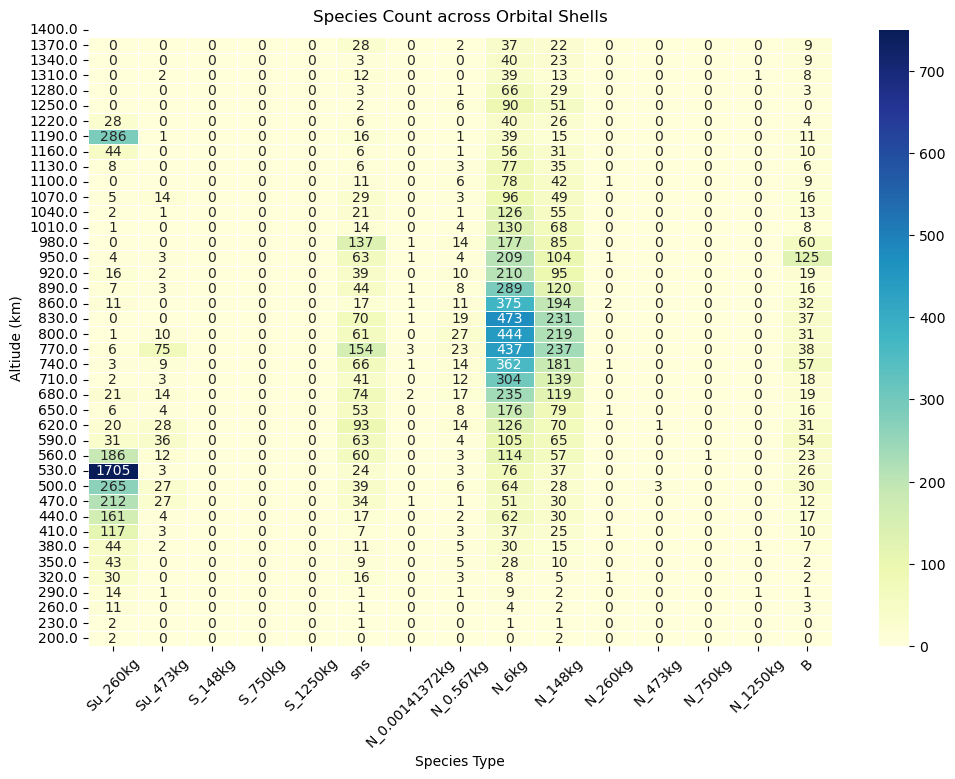

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame with orbital shells as rows and species types as columns

plt.figure(figsize=(12, 8)) # Adjust the size as needed

# Create the heatmap
sns.heatmap(scenario_properties.x0, annot=True, fmt="d", cmap="YlGnBu", linewidths=.5, vmin=0, vmax=750, yticklabels=scenario_properties.R0_km)

# Customization options
plt.gca().invert_yaxis() # Invert the y-axis to match the orbital shell order
plt.title('Species Count across Orbital Shells')
plt.xlabel('Species Type')
plt.ylabel('Altiude (km)')
plt.xticks(rotation=45) # Rotate species names for better readability

plt.show()

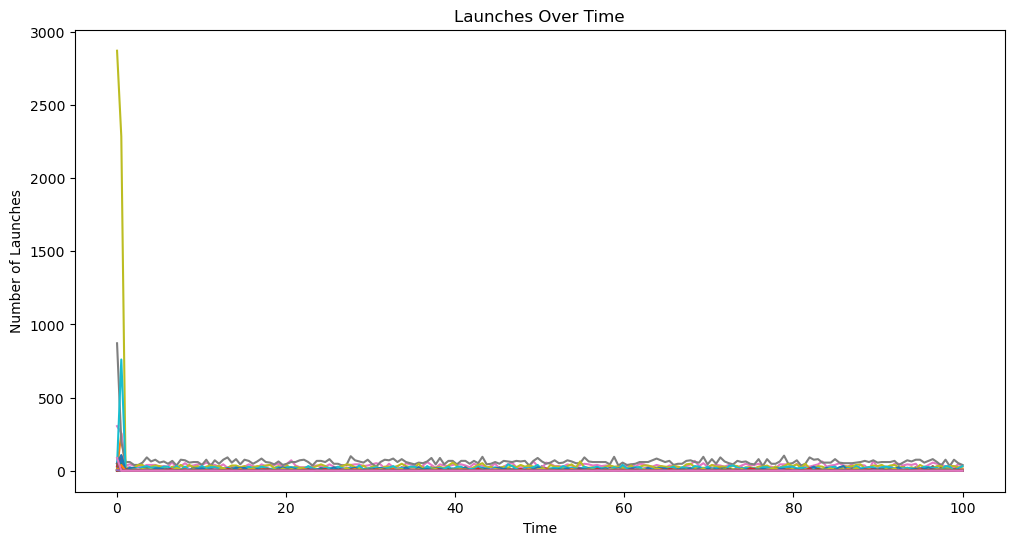

In [200]:
import numpy as np
import matplotlib.pyplot as plt

# Sample times array (replace with your actual times array)
# Let's assume each entry in the array corresponds to a time step (e.g., each year or month)
times = np.linspace(0, 100, len(scenario_properties.full_lambda[0][2])) # Adjust based on your actual scenario

# Prepare the plot
plt.figure(figsize=(12, 6))

for i, lambda_func in enumerate(scenario_properties.full_lambda):
    if lambda_func is not None:
        # Assuming 'times' is the array of times corresponding to the values in lambda_func
        plt.plot(times, lambda_func, label=f'Launches for item {i}')

plt.xlabel('Time')
plt.ylabel('Number of Launches')
plt.title('Launches Over Time')
#plt.legend()
launches_data = np.zeros((num_species, num_shells, num_time_points))
plt.show()

In [244]:
scenario_properties.full_lambda[8]

[None,
 None,
 None,
 array([0.        , 3.96014039, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 3.96014039,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 3.96014039, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 3.96014039, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 3.96014039, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 3.96014039, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 3.96014039,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.     

In [250]:
for j in range(15):
    for i in range(40):
        if scenario_properties.full_lambda[j][i] is not None:
            shell = scenario_properties.full_lambda[j][i]
        if shell is not None:
            for t in scenario_properties.scen_times:
                launch_val = np.interp(t, scenario_properties.scen_times, shell)



TypeError: 'NoneType' object is not subscriptable

In [210]:
launches_data = np.zeros((15, 40, len(scenario_properties.scen_times)))

# Directly assign the values from scenario_properties.full_lambda to launches_data
for i in range(15):  # for each species
    for j in range(40):  # for each shell
        try:
            values = scenario_properties.full_lambda[i][j]
        except Exception as e:
            continue
    
        if values is not None:  # Checking if there are values for this species-shell combination
            launches_data[i, j, :] = values
        else:
            # If None, it implies no launches, keep it as zeros.
            continue

launches_data

array([[[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  3.96014039,   7.92028079,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        ...,


In [228]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import imageio
import os


# Function to save heatmap for a specific time index
def save_heatmap(data, time_idx, species_names, r0_km, vmax=None):
    plt.figure(figsize=(12, 8))
    # Transpose the matrix to align with our axis labels correctly
    data_to_plot = data[:, :, time_idx].T
    sns.heatmap(data_to_plot, annot=True, cmap="YlGnBu", fmt=".0f", vmax=vmax,  linewidths=.5, vmin=0, 
                xticklabels=species_names, yticklabels=r0_km[::-1], cbar=False)
    plt.title(f'Launches at Simulation year {int(scenario_properties.scen_times[time_idx])}')
    plt.xlabel('Species Type')
    plt.ylabel('Altitude (km)')
    plt.gca().invert_yaxis()  # Invert the y-axis to have the highest altitude at the top
    filepath = os.path.join(os.getcwd(), f'heatmap_{time_idx}.png')
    plt.savefig(filepath)  # Save the heatmap to a file
    plt.close()
    return filepath

# Maximum value for color scaling
vmax = np.nanmax(500)  # Replace with appropriate vmax value

# Generate heatmaps for each time point and save them as individual images
filenames = []
for k in range(launches_data.shape[2]):
    filenames.append(save_heatmap(launches_data, k, scenario_properties.species_names, scenario_properties.R0_km, vmax=750))

In [229]:
import imageio

images = []
for k in range(scenario_properties.scen_times.shape[0]):
    images.append(imageio.imread(f'heatmap_{k}.png'))
imageio.mimsave('launches_over_time.gif', images, fps=2)  # Adjust fps as needed

# Clean up the images
import os

for k in range(scenario_properties.scen_times.shape[0]):
    os.remove(f'heatmap_{k}.png')


C:\Users\IT\AppData\Local\Temp\ipykernel_3216\942767040.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(f'heatmap_{k}.png'))
